# 🔎 Retrieval (and QG?) playground

In [2]:
import json, random
import matplotlib.pyplot as plt
from langchain_core.example_selectors import (
    MaxMarginalRelevanceExampleSelector,
    SemanticSimilarityExampleSelector,
)
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_community.retrievers import KNNRetriever
from IPython.display import display, Markdown, Latex
from sentence_transformers import CrossEncoder


/home/ullriher/venvs/averitec/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## ⚙️ 0. Choose claim & docstore

In [3]:
random.seed(111)

In [6]:
random.randint(0, 500)


253

In [8]:
datapoint

{'claim': 'The Nigerian government is donating $600 million to Democratic presidential nominee Joe Biden’s campaign.',
 'required_reannotation': False,
 'label': 'Refuted',
 'justification': "This claim is refuted. According to the QA pairs, there is no credible links between the alleged Nigerian government's donation of $600 million to Joe Biden. There is no evidence or credible news report about this claim. No one in the claim is on Biden's FEC campaign donors list either. Therefore, this claim is refuted.",
 'claim_date': '28-9-2020',
 'speaker': 'Biafra World News',
 'original_claim_url': 'https://web.archive.org/web/20210110235652/https://www.facebook.com/permalink.php?story_fbid=153666029728810&id=111491143946299',
 'fact_checking_article': 'https://web.archive.org/web/20210110235652/https://checkyourfact.com/2020/10/14/fact-check-nigeria-donating-600-million-bidens-campaign/',
 'reporting_source': 'Facebook',
 'location_ISO_code': 'NG',
 'claim_types': ['Event/Property Claim'],


In [7]:
CLAIM_ID = 253
datapoint = json.load(open("data/dev.json"))[CLAIM_ID]
claim = datapoint["claim"]
docstore = []
for line in open(f"data_store/output_dev/{CLAIM_ID}.json"):
    docstore.append(json.loads(line))

# print claim in markdown with some sample evidence
display(Markdown("### 🗯️ " + claim + " [" + datapoint["label"] + "]"))
# sample 3
for i in random.sample(range(len(docstore)), 3):
    newline = "\n"
    display(Markdown(f"**{docstore[i]['url']}**\n\n * {newline.join(docstore[i]['url2text'][:10])}"))

### 🗯️ The Nigerian government is donating $600 million to Democratic presidential nominee Joe Biden’s campaign. [Refuted]

**https://www.elections.virginia.gov/candidatepac-info/regulation-and-policies/**

 * All committees should familiarize themselves with the Campaign Finance Disclosure Act (CFDA). The Act can be found in the Code of Virginia, Title 24.2, Chapters 9.3, 9.4, and 9.5.
To assist in this understanding of the law, the State Board of Elections (SBE) has developed summaries on the laws and policies governing CFDA.
Be sure to read these summaries before you become a candidate, open your campaign committee, or create an account and a statement of organization in Virginia's Committee Electronic Tracking Application (COMET).
- Candidate Campaign Committee Summary of Laws and Policies
- Political Action Committee (PAC) Summary of Laws and Policies
- Attorney General’s Explanation of Personal Use (.pdf)

**https://corpgov.law.harvard.edu/2019/12/06/ending-foreign-influenced-corporate-spending-in-u-s-elections/**

 * Michael Sozan is Senior Fellow at the Center for American Progress. This post is based on his Center for American Progress report.
Related research from the Program on Corporate Governance includes Corporate Political Speech: Who Decides?
by Lucian Bebchuk and Robert J. Jackson Jr. (discussed on the Forum here); The Untenable Case for Keeping Investors in the Dark by Lucian Bebchuk, Robert J. Jackson Jr., James David Nelson, and Roberto Tallarita (discussed on the Forum here); Corporate Governance and Corporate Political Activity: What Effect will Citizens United Have on Shareholder Wealth (discussed on the Forum here) by John C. Coates, IV; and The Politics of CEOs by Alma Cohen, Moshe Hazan, Roberto Tallarita, and David Weiss (discussed on the Forum here).
The 2020 presidential election is less than a year away, and intelligence officials warn that foreign entities remain intent on affecting its outcome.
At the same time, the U.S. House of Representatives is conducting an impeachment inquiry into President Donald Trump, due in large part to his solicitation of foreign interference from Ukraine in the 2020 presidential contest.
In the midst of these threats, Americans’ trust in government is near all-time lows, with voters deeply skeptical about a political system that they believe is corrupted and dominated by corporations and wealthy special interests.
This dominance has been especially prominent since the U.S. Supreme Court’s ruling in Citizens United v. Federal Election Commission unleashed a torrent of spending directed to super PACs and shadowy nonprofit organizations.
Now more than ever, bold policy solutions are needed to help ensure that no foreign government, business, or person can unduly affect the nation’s democratic self-governance.
Before the Supreme Court’s 2010 decision in Citizens United, U.S. corporations had to finance campaign-related activity chiefly via disclosed donations from their employee-funded PACs.
Corporations were not allowed to spend money directly from their corporate treasuries on independent expenditures—advertisements that expressly call for the election or defeat of a candidate.

**https://www.dhs.gov/publication/dhsuscispia-016-computer-linked-application-information-management-system-claims-3-and**

 * U.S. Citizenship and Immigration Services (USCIS) oversees lawful immigration to the United States and is responsible for processing petitions, applications, and other requests for immigration benefits and requests.
Executive Order 13780, "Protecting the Nation from Foreign Terrorist Entry into the United States" requires the Department of Homeland Security (DHS) to collect standard data on immigration forms and in case management systems.
USCIS is now updating this Privacy Impact Assessment (PIA) to provide notice of USCIS updating certain immigration forms and associated systems, such as the Computer Linked Application Information Management System (CLAIMS 3), in support of the Executive Order 13780.
Upon publication of this PIA, USCIS will collect additional biographic and social media data elements necessary for identity verification, vetting, public safety, and national security screening.
USCIS is updating this PIA to evaluate the privacy risks and mitigations associated with these changes including the collection, use, and maintenance of additional personally identifiable information (PII).
- DHS/USCIS/ICE/CBP-001 Alien File, Index, and National File Tracking System
- DHS/USCIS-018 Immigration Biometric and Background Check
|DHS/USCIS/PIA-016(d) Computer Linked Application Management System and Associated Systems (CLAIMS 3) - June 2020
|DHS/USCIS/PIA-016(c) Computer Linked Application Information Management System (CLAIMS) 3 and Associated Systems - March 2020
|DHS/USCIS/PIA-016(b) Computer Linked Application Information Management System (CLAIMS 3) and Associated Systems - May 2019

### 🗂️ 0.1 Docstore formatting/scraping

In [30]:
# Naive version with \n concatenated url2texts:
documents = [
    Document(
        page_content=" ".join(doc["url2text"]),
        metadata={
            "url": doc["url"],
            # "sentences": doc["url2text"]
        },
    )
    for doc in docstore
]

TOKENS_PER_CHAR = 0.25
EMBEDDING_INPUT_SIZE = 512

chunks = []
for doc in docstore:
    buffer = ""
    for i, sentence in enumerate(doc["url2text"]):
        if (
            i == len(doc["url2text"]) - 1
            or len(buffer) + len(sentence) >= EMBEDDING_INPUT_SIZE / TOKENS_PER_CHAR
        ):
            context_before = ""
            if chunks and chunks[-1].metadata["url"] == doc["url"]:
                chunks[-1].metadata["context_after"] = buffer
                context_before = chunks[-1].page_content
            chunks.append(
                Document(
                    page_content=buffer,
                    metadata={"url": doc["url"], "context_before": context_before, "context_after": ""},
                )
            )

            buffer = ""
        buffer += sentence + " "
# chunk the documents into smaller pieces
chunks[random.randint(0, len(chunks))]

Document(metadata={'url': 'https://www.hrw.org/reports/1997/nigeria/Nigeria-10.htm', 'context_before': 'The Dutch government has also faced criticism for allowing a Nigerian delegation entry in March 1997, when the Netherlands, holding the presidency in the E.U., invited Nigeria to attend a meeting in Maastricht of government leaders from the fifteen-member E.U. bloc and its seventy acp partners. The European Parliament objected to the invitation, but the Dutch foreign ministry said that the visa restrictions only applied to "Nigerian authorities traveling to Europe for private reasons." A Dutch spokesman went on to say that the boycott was not intended to hinder important political discussions on the future relations between the acp and the E.U. The Dutch were of the opinions that "Nigeria is a very prominent member of the acp group: without Nigeria, the talks between the acp and the E.U. would be less significant."182 In November 1995, the United States broadened pre-existing restric

In [9]:
from utils.chat import  pretty_print

In [31]:
chid = -1

display(Markdown(chunks[chid].metadata["context_before"]))
display(Markdown(chunks[chid].page_content))
display(Markdown(chunks[chid].metadata["context_after"]))
chunks[chid].metadata["url"]

Dozens were killed and hundreds injured during clashes between protesters, riot police, and pro-Russian militia members. Yanukovych was eventually deposed as Ukrainian president before fleeing to Russia, at which point the scale of his corruption began to become apparent. In the wake of his ousting, protesters discovered that the former president had kept a 137-hectare mansion 20 miles outside Kiev, complete with its own golf-course, Spanish galleon, and ostrich farm. Mikheil Saakashvili, the former president of the Republic of Georgia, said that Yanukovych “would talk very loudly about how he had corrupted senior officials, in the supreme court and the constitutional court.” In 2016, investigators acquired a log book that showed that Yanukovych paid out more than $2 billion in bribes. Although he often declined to talk about his relationship with Yanukovych, Manafort’s financial records between him and other despots meant that these relationships weren’t exactly secrets. When it came to The Philippines’ former dictator Ferdinand Marcos, reports identified nearly $1 million flowing from the regime in Manila to Manafort’s firm, with Marcos specifically looking to Manafort and his colleagues to spin a democratic image out of his dictatorship. Mobutu Sese Seko, whose kleptocratic legacy still lingers throughout central Africa, also looked to Manafort’s team to hobnob in Washington, despite the fact that Mobutu was once described as the “archetypal African dictator” by TIME Magazine. Not to be outdone, Nigeria’s former autocrat Sani Abacha also turned to Manafort for public relations management. In addition to grave human rights violations, Abacha also appeared to be notably poor at hiding his ill-gotten gains, with the United States eventually freezing nearly a half-billion dollars in funds tied to Abacha and his family. And those are just the internationally recognized, and historically egregious, kleptocrats who Manafort helped to ravage their respective countries. 

Manafort also came to the aid of Jonas Savimbi, who was once described as the “murderous, demented Angolan rebel leader backed by the apartheid regime in South Africa.” Wrote The Daily Beast, “In his memoir, former Sen. Bill Bradley credited Savimbi’s lobbying team with lengthening” the Angolan Civil war. There are plenty of other brutal, autocratic regimes tied to Manafort’s past dealings, from the former Bakiyev regime in Kyrgyzstan – which used one of the shell companies now linked to Manafort – to Teodoro Obiang Nguema, who currently boasts the longest-tenured dictatorship in Africa. But at a certain point, listing Manafort’s list of the world’s most kleptocratic, most dictatorial, most brutal clients becomes redundant – and his proximity to the types of financial evasion of which he’s now accused become more than evident. And all of this was perfectly clear before Trump ever brought him aboard – and before he became yet another member of Trump’s campaign team now facing federal charges. 

'https://archive.thinkprogress.org/manaforts-former-clientele-27b927f175c7/'

In [32]:
from langchain_community.retrievers import BM25Retriever

retriever = BM25Retriever.from_documents(
    chunks, k=2500
)
chunks_pruned = retriever.invoke(claim)

### 📊 Docstore hist & truncation

In [12]:
len(chunks)

26427

(array([2.8000e+01, 5.0000e+01, 6.6000e+01, 6.5000e+01, 4.4000e+01,
        4.0000e+01, 4.3000e+01, 5.3000e+01, 3.4000e+01, 4.9000e+01,
        6.4000e+01, 5.3000e+01, 4.4000e+01, 5.8000e+01, 5.6000e+01,
        5.7000e+01, 6.4000e+01, 7.8000e+01, 7.4000e+01, 6.8000e+01,
        8.1000e+01, 8.3000e+01, 9.6000e+01, 9.4000e+01, 1.1700e+02,
        1.5500e+02, 1.6400e+02, 2.2600e+02, 2.8200e+02, 5.2500e+02,
        1.0130e+03, 2.2180e+03, 5.7060e+03, 1.2468e+04, 1.9330e+03,
        1.3000e+01, 1.7000e+01, 7.0000e+00, 1.0000e+01, 8.0000e+00,
        5.0000e+00, 1.0000e+00, 3.0000e+00, 5.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 0.0000e+00, 5.0000e+00, 1.0000e+00]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560.,
        1620., 1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100.,
        2160., 2220., 2280., 2340.

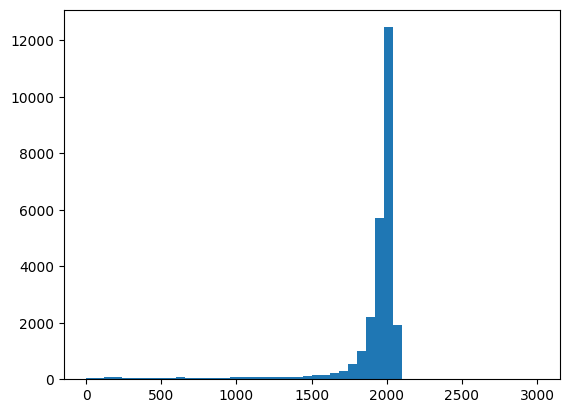

In [11]:
# histogram of sentences len, between 0 and 100
plt.hist([len(doc.page_content) for doc in chunks], bins=50, range=(0, 3000))

(array([2.4000e+01, 2.3000e+01, 2.9000e+01, 2.2000e+01, 1.9000e+01,
        2.2000e+01, 1.6000e+01, 3.4000e+01, 2.4000e+01, 2.5000e+01,
        1.9000e+01, 2.1000e+01, 3.2000e+01, 1.8000e+01, 1.9000e+01,
        3.1000e+01, 2.1000e+01, 2.5000e+01, 2.9000e+01, 2.3000e+01,
        2.4000e+01, 1.3000e+01, 2.0000e+01, 1.6000e+01, 2.0000e+01,
        1.7000e+01, 2.0000e+01, 3.5000e+01, 6.5000e+01, 1.1800e+02,
        3.3200e+02, 8.7800e+02, 5.4460e+03, 2.0798e+04, 3.3330e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560.,
        1620., 1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100.,
        2160., 2220., 2280., 2340.

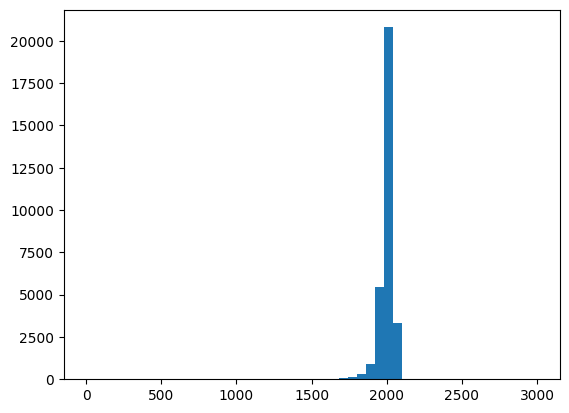

In [89]:
# histogram of sentences len, between 0 and 100
plt.hist([len(doc.page_content) for doc in chunks], bins=50, range=(0, 3000))

In [108]:
# show doc with most sentences
max_sentences = max(documents, key=lambda d: len(d.metadata["sentences"]))
max_sentences.metadata["url"]
max_sentences.page_content[:1000]

"Full text is available to Purdue University faculty, staff, and students on campus through this site.\nOff-campus Purdue users may download theses and dissertations by logging into the Libraries' proxy server with your Purdue Career Account.\nLinks to log in to the proxy server directly below the download button of each thesis or dissertation page.\nNon-Purdue users, may purchase copies of theses and dissertations from ProQuest or talk to your librarian about borrowing a copy through Interlibrary Loan.\n(Some titles may also be available free of charge in our Open Access Theses and Dissertations Series, so please check there first.)\nFortney, Sarah Katherine (2024) The Role of Trait and Specific Expectations in the Experience of Dysmenorrhea\nAbdullah, Umm E. Hani (2023) Exploratory Study of Deep Brain Stimulation in the Syngap1+/- Mouse Model of Autism Spectrum Disorder Using Electrophysiology\nAbney, Douglas John (2023) Broadband’s Role in Agricultural Job Postings In U.S. Counties\

In [110]:
# trim document page contents to 13000 characters
for doc in documents:
    doc.page_content = doc.page_content[:13000]

## 📐 1. Embedding searches

In [9]:
embeddings = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

In [112]:
reranker = KNNRetriever.from_documents(documents, embeddings, k=10)
results = reranker.get_relevant_documents(claim)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + "*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1*



**https://www.nzherald.co.nz/nz/judith-collins-accused-of-potential-conflict-of-interest/NXKZLIY4IZNGIN6GKTNQZQSJWQ/**

Justice Minister Judith Collins has been accused of potentially breaching conflict of interest rules for Cabinet ministers after a visit to a company her husband is a director of while in China.
One News reported that while Ms Collins was in China last Oct

**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

Justice Minister Judith Collins said she told milk product company Oravida that it could not use her photograph or name to endorse its products prior to visiting it in China last year and although its milk was "nice" that was not an endorsement of the comp

**https://eitr545824759.wordpress.com/2020/08/08/judith-collins-david-wong-tung-and-the-oravida-kauri-ltd-ruakaka-connection-and-that-broken-marsden-point-fuel-line-breakage-that-caused-nz-48m-in-economic-damage-no-one-has-subsequently-been-charged/**

David Wong-Tung, the husband of then energy minister Judith Collins, was a director of Kauri Ruakaka until 2017, but is no longer on its board.
Former Engineering NZ president Elena Trout who headed the inquiry, said it understood the contractor sold swamp

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars.
Oravida pays about $500 a year to draw up

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

When Judith wasn’t questionably meeting Chinese border officials or diverting to its trade events, Oravida also exported swamp Kauri.
The above quote was when Judith was challenged that Oravida was damaging the environment.
What a sad day for Judith, appar

**https://www.newshub.co.nz/home/money/2016/04/oravida-jumps-in-to-export-kiwi-water.html**

New Zealand water could be the next big export to China and one of the companies that has just jumped in for a slice of the pie is none other than Oravida.
The company is only paying a small amount to the council for the millions of litres it can take.
Sto

**https://thedailyblog.co.nz/2014/03/05/crusher-collins-conflict-of-interest-seems-as-large-as-her-interest-in-conflict/**

Collins says Oravida visit not conflict of interest
Judith Collins went on a taxpayer-funded visit to China last year. In her public role as Justice Minister, she was there to talk about our system.
But she was also welcomed into a New Zealand export compa

**https://www.newshub.co.nz/home/new-zealand/2015/10/greens-mp-apologises-over-swamp-kauri-claim.html**

A Green MP has apologised to Judith Collins' husband following a press release condemning the extraction of valuable swamp kauri.
In a statement released by the party's conservation spokeswoman Eugenie Sage in June, she called for the illegal export of anc

**https://www.odt.co.nz/business/nz-milk-fetches-big-bucks-china**

You are not permitted to download, save or email this image. Visit image gallery to purchase the image.
But the high-price reflects a more complicated supply chain - and the degree to which the high-quality product is sought after in China.
It's just one o

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.”
So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

## 📐 Max. Marginal relevance


In [92]:
%pip install --upgrade --quiet  rank_bm25

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You should consider upgrading via the '/home/ullriher/venvs/averitec/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [55]:
from langchain_community.retrievers import BM25Retriever

retriever = BM25Retriever.from_documents(
    chunks, k=3000
)
chunks_pruned = retriever.invoke(claim)

In [109]:
len(chunks_pruned)

1500

In [110]:
chroma = Chroma(f"dev_{CLAIM_ID}_mxbai", persist_directory=f"data_store/vector_store_dev/{CLAIM_ID}")
chroma.delete_collection()
documents_ = [doc.copy() for doc in chunks_pruned]
for doc in documents_:
    if 'sentences' in doc.metadata:
        doc.metadata.pop("sentences", None)
    
chroma = chroma.from_documents(documents_, embeddings)


In [106]:
# make or overwrite /home/ullriher/aic_averitec/data_store/vector_store_dev/CLAIM_ID and persist chroma there
!mkdir -p /home/ullriher/aic_averitec/data_store/vector_store_dev/{CLAIM_ID}
chroma(f"/home/ullriher/aic_averitec/data_store/vector_store_dev/{CLAIM_ID}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


AttributeError: 'Chroma' object has no attribute 'persist'

In [114]:
claim

'New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.'

In [14]:
embeddings = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

In [56]:
len(chunks_pruned)

3000

In [58]:
from langchain_community.retrievers import BM25Retriever

retriever = BM25Retriever.from_documents(
    chunks, k=6000
)
chunks_pruned = retriever.invoke(claim)

In [1]:
from langchain_community.vectorstores import FAISS

db = FAISS.from_documents(chunks_pruned, embeddings)
db.save_local(f"data_store/vecstore/dev/6k/{CLAIM_ID}")

NameError: name 'chunks_pruned' is not defined

In [10]:
from langchain_community.vectorstores import FAISS

db = FAISS.load_local(f"data_store/vecstore/dev/6k/{CLAIM_ID}", embeddings,allow_dangerous_deserialization=True)

In [11]:
from utils.chat import SimpleJSONChat

chat = SimpleJSONChat(
    model="gpt-4o",
    system_prompt=f"""Pretend you are a researcher who receives a claim where your goal is to be as unbiased as possible. There are two teams: Query Generation (your team) and Information Acquisition. The goal of your team is to generate pertinent queries based on the claim such that when queried on Google/Bing, the results will be accurate and helpful in finding relevant sources. The second team then uses those sources to further refine whether the claim is supported (true), unsupported (false), or cherry picked (conflicting evidence). In summary, you will receive a claim and the task is to generate 10 queries that are relevant to the claim, paying mind to the different possible labels (i.e ensure the generated queries cover all possible labels). A necessary requirement is to include metadata like claim date, speaker, and reporting source. Use your imagination and take time to be thoughtful with queries, ensuring relevance to the claim. The queries should be formatted in a manner ready for querying via Google/Bing API, so no need for extra text or explanations intended for a user.""",
    parse_output=False,
)

In [12]:
datapoint

{'claim': 'The Nigerian government is donating $600 million to Democratic presidential nominee Joe Biden’s campaign.',
 'required_reannotation': False,
 'label': 'Refuted',
 'justification': "This claim is refuted. According to the QA pairs, there is no credible links between the alleged Nigerian government's donation of $600 million to Joe Biden. There is no evidence or credible news report about this claim. No one in the claim is on Biden's FEC campaign donors list either. Therefore, this claim is refuted.",
 'claim_date': '28-9-2020',
 'speaker': 'Biafra World News',
 'original_claim_url': 'https://web.archive.org/web/20210110235652/https://www.facebook.com/permalink.php?story_fbid=153666029728810&id=111491143946299',
 'fact_checking_article': 'https://web.archive.org/web/20210110235652/https://checkyourfact.com/2020/10/14/fact-check-nigeria-donating-600-million-bidens-campaign/',
 'reporting_source': 'Facebook',
 'location_ISO_code': 'NG',
 'claim_types': ['Event/Property Claim'],


In [13]:
claim

'The Nigerian government is donating $600 million to Democratic presidential nominee Joe Biden’s campaign.'

In [14]:
res = chat(claim+f" (Speaker: {datapoint['speaker']}, {datapoint['claim_date']})")
res

'1. Nigerian government $600 million donation Joe Biden campaign 2020\n2. Biafra World News Nigerian government donation Joe Biden 28-9-2020\n3. Nigerian government financial support Joe Biden presidential campaign\n4. Nigerian government foreign donations US elections 2020\n5. Joe Biden campaign foreign donations 2020\n6. Nigerian government political donations 2020\n7. Biafra World News Joe Biden campaign funding 28-9-2020\n8. Nigerian government $600 million donation verification\n9. US election laws foreign donations Joe Biden 2020\n10. Nigerian government involvement US elections 2020'

In [15]:
def parse(res):
    result = []
    lines = res.strip().split("\n")

    # Parse each line to extract the content
    parsed_results = [line.split(". ")[1].strip('"') for line in lines]

    # Print the parsed results
    for item in parsed_results:
        result.append(item)
    return result

In [26]:
CLAIM_ID = 253
CLAIM_ID = random.choice(range(500))
datapoint = json.load(open("data/dev.json"))[CLAIM_ID]
claim = datapoint["claim"]

res = chat(claim+f" (Speaker: {datapoint['speaker']}, {datapoint['claim_date']})")
db = FAISS.load_local(f"data_store/vecstore/dev/6k/{CLAIM_ID}", embeddings,allow_dangerous_deserialization=True)

display(Markdown(f"## 🗯️ {CLAIM_ID}: {claim} [{datapoint['label']}]"))

for query in parse(res):
    results = db.similarity_search(query, 2)

    display(Markdown("### 🔎 " + query))
    # sample 3
    for r in results:
        newline = "\n"
        display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content}"))

## 🗯️ 322: Trump nixes aid for California fires but offers help to Putin for Siberian wildfires. [Refuted]

### 🔎 Trump cancels aid for California wildfires September 2020

**https://www.cbsnews.com/losangeles/news/president-trump-says-he-is-halting-fema-wildfire-aid-to-calif/**

President Trump Says He Is Halting FEMA Wildfire Aid To Calif. LOS ANGELES (CBSLA/AP) – President Donald Trump announced Wednesday that he has ordered the Federal Emergency Management Agency to stop sending wildfire relief money to California. In an early morning tweet, Mr. Trump blamed the state's forest management for its recent slew of historically-large wildfires which have leveled entire communities up and down the state. "Billions of dollars are sent to the State of California for Forrest (sic) fires that, with proper Forrest (sic) Management, would never happen," Mr. Trump wrote. "Unless they get their act together, which is unlikely, I have ordered FEMA to send no more money. It is a disgraceful situation in lives & money!" Mr. Trump misspelled "forest" twice in the tweet. About 30 minutes later, Mr. Trump deleted the tweet and resent it with the proper spelling. FEMA has so far approved 6,646 applications and more than $48.7 million in aid related to the Woolsey Fire and the Camp Fire, according to the agency's website. FEMA grants do not have to be repaid and are non-taxable. Late Tuesday, FEMA announced that the deadline to apply for aid had been extended from Friday, Jan. 11, to Jan. 31. It's unclear how Mr. Trump's supposed new order could affect those applications. FEMA did not immediately respond to a request for comment from CBS2. "Disasters and recovery are no time for politics," new California Gov. Gavin Newsom tweeted Wednesday in response to the president. "Mr. President -- Just yesterday, @OregonGovBrown, @GovInslee, and I sent a letter asking the federal government to work with us in taking on these unprecedented wildfires. We have been put in office by the voters to get things done, not to play games with lives." Going back to last summer, Mr. Trump has repeatedly criticized California officials, alleging they are at fault for not doing enough to prevent the wildfires and threatening to withhold federal funding. 

**https://www.bbc.com/news/world-us-canada-50284656**

California fires: Trump threatens to pull federal aid US President Donald Trump has threatened to cut federal funding for the wildfires sweeping California, in a Twitter spat with the state's governor. Nearly 100,000 acres have been destroyed by wildfires in recent weeks, and thousands have been forced from their homes. Mr Trump blamed Governor Gavin Newsom, a Democrat, saying he had done a "terrible job of forest management". Several of this year's major wildfires have burned in unforested areas. "Every year, as the fire's (sic) rage & California burns, it is the same thing - and then he comes to the Federal Government for $$$ help. No more. Get your act together Governor," Mr Trump wrote on Twitter. Mr Newsom, who has been highly critical of Mr Trump's environmental policies, responded: "You don't believe in climate change. Increased temperatures due to global warming are causing huge wildfires in California, according to a recent study published in the Proceedings of the National Academy of Sciences. Drier, warmer conditions lead to vegetation drying out and becoming more flammable. President Trump made a similar threat to cut federal aid in 2018, when the most deadly fire in California's history killed 86 people. In California, 57% of forested areas are managed by federal agencies such as the US Forest Service, the Bureau of Land Management and the National Park Service. In 2018, the state requested $72 million (£55.6 million) in reimbursements from the US Forest Service, with $9 million (£7 million) of that money withheld, the Los Angeles Times reports. Firefighters have contained about half of the Maria Fire, the major blaze in southern California. The fire, which broke out on Thursday, has burned more than 9,400 acres, the Ventura County Fire Department said on Sunday. 

### 🔎 Trump offers assistance to Putin for Siberian wildfires September 2020

**https://uk.news.yahoo.com/trump-offers-putin-help-siberian-220337446.html/1000**

Trump offers Putin help with Siberian wildfires - Kremlin MOSCOW (Reuters) - U.S. President Donald Trump offered his Russian counterpart Vladimir Putin help in putting out vast wildfires that are raging in Siberia, the Kremlin said late on Wednesday, a move it said Putin took as a sign that battered ties can be restored. The Kremlin said the two leaders had spoken by phone at Washington's initiative, hours after Putin ordered the Russian army to help firefighters battle the wildfires. The fires have spread to around 3 million hectares of mostly remote forest, an area almost the size of Belgium, according to the Federal Forestry Agency, wafting smoke across Siberia and prompting several regions to declare states of emergency. "The U.S. president offered Russia cooperation in fighting forest fires in Siberia," the Kremlin statement said. "President Putin expressed his sincere gratitude for such an attentive attitude and for the offer of help and support." Putin told Trump that Moscow would take him up on his offer if necessary, the Kremlin said, adding: "The Russian president took this step from the U.S. president as a sign that in the future we can restore full-scale ties between our two countries." Russia has long been keen to try to start rebuilding battered U.S.-Russia relations, which remain strained by everything from Syria to Ukraine and allegations of Russian interference in U.S. politics, which Moscow denies. The two leaders agreed to continue their contacts over the phone and in face-to-face meetings, the Kremlin said. 

**https://tass.com/world/1071330**

MOSCOW, July 31. /TASS/. US President Donald Trump has offered help in extinguishing wildfires in Siberia in a telephone conversation with Russian President Vladimir Putin held on Washington's initiative, the Kremlin press service said on Wednesday. "A telephone conversation between Vladimir Putin and Donald Trump was held tonight upon the US initiative. The US president offered to help Russia with extinguishing wildfires in Siberia," the Kremlin said. The Russian president expressed sincere gratitude to Trump "for such attentive attitude, for offering help and support." Putin noted that Russia will accept the offer if needed. The Kremlin said that Putin told Trump that an effective aviation group has been set up in Siberia for combating wildfires. The Russian Emergencies Ministry said earlier that "there are some difficulties, but issues of refueling and stationing aircraft and helicopters are being resolved." According to the Aerial Forest Protection Service, as of July 31 wildfires are blazing on the territory of nearly 2.8 mln hectares in the control zone (hard to access zone). Largest wildfires are registered in Yakutia (1.1 mln hectares), Krasnoyarsk (over 1 mln hectares) and Irkutsk (around 700,000 hectares) regions. Over 2,700 people, 390 units of ground equipment and 28 aircraft are involved in extinguishing wildfires. A state of emergency over forest fires was declared in Irkutsk and Krasnoyarsk regions, as well as in two districts of Buryatia region and one district of Yakutia region. On Wednesday, Putin ordered 10 aircraft and 10 helicopters of the Russian Defense Ministry to join the firefighting efforts. Russian Prime Minister Dmitry Medvedev held a session in Krasnoyarsk on the situation with Siberian wildfires. 

### 🔎 David C Ryder Trump California fire aid cancellation

**https://www.cbsnews.com/losangeles/news/president-trump-says-he-is-halting-fema-wildfire-aid-to-calif/**

President Trump Says He Is Halting FEMA Wildfire Aid To Calif. LOS ANGELES (CBSLA/AP) – President Donald Trump announced Wednesday that he has ordered the Federal Emergency Management Agency to stop sending wildfire relief money to California. In an early morning tweet, Mr. Trump blamed the state's forest management for its recent slew of historically-large wildfires which have leveled entire communities up and down the state. "Billions of dollars are sent to the State of California for Forrest (sic) fires that, with proper Forrest (sic) Management, would never happen," Mr. Trump wrote. "Unless they get their act together, which is unlikely, I have ordered FEMA to send no more money. It is a disgraceful situation in lives & money!" Mr. Trump misspelled "forest" twice in the tweet. About 30 minutes later, Mr. Trump deleted the tweet and resent it with the proper spelling. FEMA has so far approved 6,646 applications and more than $48.7 million in aid related to the Woolsey Fire and the Camp Fire, according to the agency's website. FEMA grants do not have to be repaid and are non-taxable. Late Tuesday, FEMA announced that the deadline to apply for aid had been extended from Friday, Jan. 11, to Jan. 31. It's unclear how Mr. Trump's supposed new order could affect those applications. FEMA did not immediately respond to a request for comment from CBS2. "Disasters and recovery are no time for politics," new California Gov. Gavin Newsom tweeted Wednesday in response to the president. "Mr. President -- Just yesterday, @OregonGovBrown, @GovInslee, and I sent a letter asking the federal government to work with us in taking on these unprecedented wildfires. We have been put in office by the voters to get things done, not to play games with lives." Going back to last summer, Mr. Trump has repeatedly criticized California officials, alleging they are at fault for not doing enough to prevent the wildfires and threatening to withhold federal funding. 

**https://www.latimes.com/politics/story/2020-08-17/trump-sought-to-withhold-california-fire**

Trump sought to withhold California fire aid because of politics, former official says The former chief of staff at the Department of Homeland Security claims in a political ad released Monday that President Trump tried to withhold disaster relief money for California’s wildfires because voters in the state opposed him politically. “He told us to stop giving money to people whose houses had burned down from a wildfire because he was so rageful that people in the state of California didn’t support him and that politically it wasn’t a base for him,” Miles Taylor, who left the Trump administration in 2019, claims in the ad. “A lot of the time, the things he wanted to do not only were impossible but, in many cases, illegal,” Taylor said, recalling how Trump “didn’t want” to hear aides inform him that his policies wouldn’t stand up to legal challenges. “These were his words: He knew that he had ‘magical authorities,’” Taylor said, recalling a phrase he said Trump used to brush off questions from aides. The Department of Homeland Security oversees the Federal Emergency Management Agency. Taylor doesn’t say which wildfires he is referring to, but the group running the ad confirmed it was the Camp fire of 2018, and Trump toured the devastation in Paradise that year. No evidence has surfaced to show that federal aid was withheld, despite public threats from Trump at the time, who said he would withhold money because he disapproved of the state’s forest management practices. Taylor took a job at Google after leaving the Trump administration and is on leave, according to his Twitter profile. The two-minute ad, promoted by a group called Republican Voters Against Trump, follows sharp criticism from several former top White House aides and others, including former National Security Advisor John Bolton, who have questioned Trump’s fitness to serve a second term. The ad was released on the first day of the Democratic National Convention, which will nominate former Vice President Joe Biden to run against the incumbent. 

### 🔎 Trump administration response to California wildfires 2020

**https://archive.thinkprogress.org/trump-west-coast-fema-california-wildfire-aid-25b9e5cd2926/**

One instructs state agencies to consider the science of fires along with “social vulnerability factors,” like economic status, designed to mitigate the impact on California’s more vulnerable communities, including the elderly. The second empowers agencies to work with the private sector in order to help mitigate and address wildfires. Those moves come after Trump sparred repeatedly last year with California officials over the wildfires, accusing the state of “gross mismanagement” of its forests. He additionally threatened to withhold federal funds to the state, prompting widespread criticism from firefighters, scientists, and other stakeholders. Both Trump and former Interior Secretary Ryan Zinke claimed repeatedly that poor forest management caused the deadly wildfires; while experts tend to agree there should be more funding for forest maintenance, they emphasize the issue is far from the only factor contributing to wildfires. Since taking office, the Trump administration has notably cut the Forest Service’s budget by some $2 billion. The agency has also been hit hard by the shutdown, with training halted for thousands of firefighters in the West and federal employees unable to perform a number of their traditional duties. That includes suspending “pile burns,” which involve burning off timber in winter months in order to reduce wildfires later on in the year. Trump’s decision to reignite arguments over the wildfires on Wednesday indicates West Coast governors may be unlikely to find the relief they are seeking from the White House. CAL Fire, the state’s fire agency, did not immediately respond to ThinkProgress’ request for comment regarding Trump’s tweet was not met with an immediate response. But Democrats fired back on Wednesday, including California Sens. Dianne Feinstein and Kamala Harris, offering criticisms of Trump and calling for aid for California. 

**https://www.c-span.org/video/?475801-1/president-trump-meets-california-officials-wildfires**

President Trump Meets with California Officials on Wildfires President Trump participated in a briefing with Governor Gavin Newsom (D) at Sacramento McClellan Airport on the California wildfires. President Trump participated in a briefing with Governor Gavin Newsom (D) at Sacramento McClellan Airport on the California wildfires. State and local officials briefed the president on the historically devastating wildfires ravaging the state. California Natural Resources Secretary Wade Crowfoot implored President Trump to consider the impact of climate change. “It’ll start getting cooler, you just watch,” said the president. “I wish science agreed with you,” replied Mr. Crowfoot. “I don’t think science knows, actually,” President Trump retorted. close Wade Crowfoot Secretary California->Natural Resources Agency Peter Gaynor Acting Administrator (Former) Federal Emergency Management Agency Mark Ghilarducci Director California->Governor's Office of Emergency Services Thom Porter Director California Department of Forestry and Fire Protection Chad Wolf Acting Secretary Department of Homeland Security Representative Jared Huffman on Wildfires and Climate Change Representative Jared Huffman (D-CA) talked about the wildfires in the West and climate change. California Governor Newsom Coronavirus News Conference California Governor Gavin Newsom (D) held a briefing on the state’s response to the coronavirus pandemic. California Governor Newsom Coronavirus News Conference California Governor Gavin Newsom (D) provided an update on the state’s ongoing response to the coronavirus pandemic. California Governor Newsom Coronavirus News Conference 

### 🔎 US aid to Russia for Siberian wildfires 2020

**https://tass.com/world/1071330**

MOSCOW, July 31. /TASS/. US President Donald Trump has offered help in extinguishing wildfires in Siberia in a telephone conversation with Russian President Vladimir Putin held on Washington's initiative, the Kremlin press service said on Wednesday. "A telephone conversation between Vladimir Putin and Donald Trump was held tonight upon the US initiative. The US president offered to help Russia with extinguishing wildfires in Siberia," the Kremlin said. The Russian president expressed sincere gratitude to Trump "for such attentive attitude, for offering help and support." Putin noted that Russia will accept the offer if needed. The Kremlin said that Putin told Trump that an effective aviation group has been set up in Siberia for combating wildfires. The Russian Emergencies Ministry said earlier that "there are some difficulties, but issues of refueling and stationing aircraft and helicopters are being resolved." According to the Aerial Forest Protection Service, as of July 31 wildfires are blazing on the territory of nearly 2.8 mln hectares in the control zone (hard to access zone). Largest wildfires are registered in Yakutia (1.1 mln hectares), Krasnoyarsk (over 1 mln hectares) and Irkutsk (around 700,000 hectares) regions. Over 2,700 people, 390 units of ground equipment and 28 aircraft are involved in extinguishing wildfires. A state of emergency over forest fires was declared in Irkutsk and Krasnoyarsk regions, as well as in two districts of Buryatia region and one district of Yakutia region. On Wednesday, Putin ordered 10 aircraft and 10 helicopters of the Russian Defense Ministry to join the firefighting efforts. Russian Prime Minister Dmitry Medvedev held a session in Krasnoyarsk on the situation with Siberian wildfires. 

**https://uk.news.yahoo.com/trump-offers-putin-help-siberian-220337446.html/1000**

Trump offers Putin help with Siberian wildfires - Kremlin MOSCOW (Reuters) - U.S. President Donald Trump offered his Russian counterpart Vladimir Putin help in putting out vast wildfires that are raging in Siberia, the Kremlin said late on Wednesday, a move it said Putin took as a sign that battered ties can be restored. The Kremlin said the two leaders had spoken by phone at Washington's initiative, hours after Putin ordered the Russian army to help firefighters battle the wildfires. The fires have spread to around 3 million hectares of mostly remote forest, an area almost the size of Belgium, according to the Federal Forestry Agency, wafting smoke across Siberia and prompting several regions to declare states of emergency. "The U.S. president offered Russia cooperation in fighting forest fires in Siberia," the Kremlin statement said. "President Putin expressed his sincere gratitude for such an attentive attitude and for the offer of help and support." Putin told Trump that Moscow would take him up on his offer if necessary, the Kremlin said, adding: "The Russian president took this step from the U.S. president as a sign that in the future we can restore full-scale ties between our two countries." Russia has long been keen to try to start rebuilding battered U.S.-Russia relations, which remain strained by everything from Syria to Ukraine and allegations of Russian interference in U.S. politics, which Moscow denies. The two leaders agreed to continue their contacts over the phone and in face-to-face meetings, the Kremlin said. 

### 🔎 Trump California wildfire aid decision September 2020

**https://www.cbsnews.com/losangeles/news/president-trump-says-he-is-halting-fema-wildfire-aid-to-calif/**

President Trump Says He Is Halting FEMA Wildfire Aid To Calif. LOS ANGELES (CBSLA/AP) – President Donald Trump announced Wednesday that he has ordered the Federal Emergency Management Agency to stop sending wildfire relief money to California. In an early morning tweet, Mr. Trump blamed the state's forest management for its recent slew of historically-large wildfires which have leveled entire communities up and down the state. "Billions of dollars are sent to the State of California for Forrest (sic) fires that, with proper Forrest (sic) Management, would never happen," Mr. Trump wrote. "Unless they get their act together, which is unlikely, I have ordered FEMA to send no more money. It is a disgraceful situation in lives & money!" Mr. Trump misspelled "forest" twice in the tweet. About 30 minutes later, Mr. Trump deleted the tweet and resent it with the proper spelling. FEMA has so far approved 6,646 applications and more than $48.7 million in aid related to the Woolsey Fire and the Camp Fire, according to the agency's website. FEMA grants do not have to be repaid and are non-taxable. Late Tuesday, FEMA announced that the deadline to apply for aid had been extended from Friday, Jan. 11, to Jan. 31. It's unclear how Mr. Trump's supposed new order could affect those applications. FEMA did not immediately respond to a request for comment from CBS2. "Disasters and recovery are no time for politics," new California Gov. Gavin Newsom tweeted Wednesday in response to the president. "Mr. President -- Just yesterday, @OregonGovBrown, @GovInslee, and I sent a letter asking the federal government to work with us in taking on these unprecedented wildfires. We have been put in office by the voters to get things done, not to play games with lives." Going back to last summer, Mr. Trump has repeatedly criticized California officials, alleging they are at fault for not doing enough to prevent the wildfires and threatening to withhold federal funding. 

**https://archive.thinkprogress.org/trump-west-coast-fema-california-wildfire-aid-25b9e5cd2926/**

One instructs state agencies to consider the science of fires along with “social vulnerability factors,” like economic status, designed to mitigate the impact on California’s more vulnerable communities, including the elderly. The second empowers agencies to work with the private sector in order to help mitigate and address wildfires. Those moves come after Trump sparred repeatedly last year with California officials over the wildfires, accusing the state of “gross mismanagement” of its forests. He additionally threatened to withhold federal funds to the state, prompting widespread criticism from firefighters, scientists, and other stakeholders. Both Trump and former Interior Secretary Ryan Zinke claimed repeatedly that poor forest management caused the deadly wildfires; while experts tend to agree there should be more funding for forest maintenance, they emphasize the issue is far from the only factor contributing to wildfires. Since taking office, the Trump administration has notably cut the Forest Service’s budget by some $2 billion. The agency has also been hit hard by the shutdown, with training halted for thousands of firefighters in the West and federal employees unable to perform a number of their traditional duties. That includes suspending “pile burns,” which involve burning off timber in winter months in order to reduce wildfires later on in the year. Trump’s decision to reignite arguments over the wildfires on Wednesday indicates West Coast governors may be unlikely to find the relief they are seeking from the White House. CAL Fire, the state’s fire agency, did not immediately respond to ThinkProgress’ request for comment regarding Trump’s tweet was not met with an immediate response. But Democrats fired back on Wednesday, including California Sens. Dianne Feinstein and Kamala Harris, offering criticisms of Trump and calling for aid for California. 

### 🔎 Trump Putin Siberian wildfires assistance September 2020

**https://tass.com/world/1071330**

MOSCOW, July 31. /TASS/. US President Donald Trump has offered help in extinguishing wildfires in Siberia in a telephone conversation with Russian President Vladimir Putin held on Washington's initiative, the Kremlin press service said on Wednesday. "A telephone conversation between Vladimir Putin and Donald Trump was held tonight upon the US initiative. The US president offered to help Russia with extinguishing wildfires in Siberia," the Kremlin said. The Russian president expressed sincere gratitude to Trump "for such attentive attitude, for offering help and support." Putin noted that Russia will accept the offer if needed. The Kremlin said that Putin told Trump that an effective aviation group has been set up in Siberia for combating wildfires. The Russian Emergencies Ministry said earlier that "there are some difficulties, but issues of refueling and stationing aircraft and helicopters are being resolved." According to the Aerial Forest Protection Service, as of July 31 wildfires are blazing on the territory of nearly 2.8 mln hectares in the control zone (hard to access zone). Largest wildfires are registered in Yakutia (1.1 mln hectares), Krasnoyarsk (over 1 mln hectares) and Irkutsk (around 700,000 hectares) regions. Over 2,700 people, 390 units of ground equipment and 28 aircraft are involved in extinguishing wildfires. A state of emergency over forest fires was declared in Irkutsk and Krasnoyarsk regions, as well as in two districts of Buryatia region and one district of Yakutia region. On Wednesday, Putin ordered 10 aircraft and 10 helicopters of the Russian Defense Ministry to join the firefighting efforts. Russian Prime Minister Dmitry Medvedev held a session in Krasnoyarsk on the situation with Siberian wildfires. 

**https://www.bloomberg.com/news/articles/2019-07-31/trump-offered-putin-u-s-help-fighting-wildfires-kremlin-says/undefined**

Trump Offered Putin U.S. Help Fighting Wildfires, Kremlin Says - About 3 million hectares are burning in Siberia, agency says - U.S. wildfires haven’t always drawn president’s sympathy Donald Trump called Russian President Vladimir Putin on Wednesday to offer U.S. help fighting Siberian wildfires, the Kremlin said in a statement. Putin thanked Trump for the offer but said a group of airplanes had been formed in Siberia to fight the fires, according to a translation of the statement. 

### 🔎 Federal aid for California wildfires 2020 Trump

**https://www.cbsnews.com/losangeles/news/president-trump-says-he-is-halting-fema-wildfire-aid-to-calif/**

President Trump Says He Is Halting FEMA Wildfire Aid To Calif. LOS ANGELES (CBSLA/AP) – President Donald Trump announced Wednesday that he has ordered the Federal Emergency Management Agency to stop sending wildfire relief money to California. In an early morning tweet, Mr. Trump blamed the state's forest management for its recent slew of historically-large wildfires which have leveled entire communities up and down the state. "Billions of dollars are sent to the State of California for Forrest (sic) fires that, with proper Forrest (sic) Management, would never happen," Mr. Trump wrote. "Unless they get their act together, which is unlikely, I have ordered FEMA to send no more money. It is a disgraceful situation in lives & money!" Mr. Trump misspelled "forest" twice in the tweet. About 30 minutes later, Mr. Trump deleted the tweet and resent it with the proper spelling. FEMA has so far approved 6,646 applications and more than $48.7 million in aid related to the Woolsey Fire and the Camp Fire, according to the agency's website. FEMA grants do not have to be repaid and are non-taxable. Late Tuesday, FEMA announced that the deadline to apply for aid had been extended from Friday, Jan. 11, to Jan. 31. It's unclear how Mr. Trump's supposed new order could affect those applications. FEMA did not immediately respond to a request for comment from CBS2. "Disasters and recovery are no time for politics," new California Gov. Gavin Newsom tweeted Wednesday in response to the president. "Mr. President -- Just yesterday, @OregonGovBrown, @GovInslee, and I sent a letter asking the federal government to work with us in taking on these unprecedented wildfires. We have been put in office by the voters to get things done, not to play games with lives." Going back to last summer, Mr. Trump has repeatedly criticized California officials, alleging they are at fault for not doing enough to prevent the wildfires and threatening to withhold federal funding. 

**https://abcnews.go.com/Politics/trump-threatens-cut-fema-funds-aid-california-fires/story?id=60266212**

Trump threatens to cut FEMA funds to aid California fires "It is a disgraceful situation in lives & money,” Trump stated. President Donald Trump threatened to end federal emergency funding to help aid California’s destructive wildfires on Wednesday. Trump tweeted that "billions of dollars" are sent to California and with proper forest management, the forest fires ‘would never happen’. “Unless they get their act together, which is unlikely, I have ordered FEMA to send no more money. It is a disgraceful situation in lives & money,” he stated in his tweet. Although the president is casting blame on California officials, most of California's forests are owned and managed by federal agencies. Federal agencies manage 57 percent of the approximately 33 million acres of forest in the state, according to research done by the University of California. This time of the year, the forest management teams are busy -- removing brush, dead trees, and clearing trails. But as the government shut down lingers, the U.S. Forest Service can only respond and try to put out fires, while they aren't being paid. That means there is little to no work being done to manage forests while the government is closed, except responding to immediate safety issues. "The people of CA – folks in Paradise – should not be victims to partisan bickering," Newsom stated saying he's ready to take action on modernizing forest and emergency responses. President Trump surveyed the devastation from the California wildfires in November touring Paradise and Malibu, two areas charred by the flames. At the time, he pledged the full support of the federal government in recovery efforts. Trump also met with then governor-elect Newsom and former governor Jerry Brown. During that trip, the president also blamed "poor forest management" for the severity of the fires. More than 13,000 families lost their homes from the fires that ripped through Butte County in Northern California. 

### 🔎 Trump's international aid offers 2020

**https://www.justice-integrity.org/news-reports/2013-oct-2023-news**

It is not exactly clear how much funding the president will propose for each program, and the people familiar with the matter cautioned that planning remains in flux. They spoke on the condition of anonymity because the details are not final, and the size of the total proposal could still change. As 2024 looms, Biden unveils $106 billion foreign aid package Coming as the president focuses his attention on the Israel-Gaza war, the proposal reflects urgent domestic needs as well as the administration’s attempt to show that Biden is working to improve the U.S. economy, a source of dissatisfaction among many voters. The legislation is highly unlikely to pass a Republican-controlled House, where hard-line members have demanded aggressive cuts to government services, but it may help the administration respond to a potential political vulnerability. Some Democrats want Biden to push for action on domestic legislation while also supporting U.S. allies abroad. On Friday, the White House unveiled an approximately $106 billion aid package primarily focused on funding for Ukraine and Israel, while also calling for billions in aid for the U.S.-Mexico border and global humanitarian assistance. Its fate is also unclear in Congress, but that bill is much more likely to garner bipartisan support. Washington Post, Shouting down an election-denial question embodies the Republicans’ problem, Philip Bump, Oct. 25, 2023. The House Republicans were giddy, boisterous, maybe a little punch-drunk after a lengthy day — at the end of a lengthy several weeks — spent trying to select a new leader for their party’s conference. They had at last landed on one, Rep. Mike Johnson (R-La.), and crowded around him as he answered questions from reporters. Keeping up with politics is easy with The 5-Minute Fix Newsletter, in your inbox weekdays. “Mr. Johnson,” she began, “you helped lead the effort to overturn the 2020 election results —” Johnson began shaking his head, a disappointed look on his face. His colleagues around him began to groan. 

**https://www.boston.com/news/politics/2018/11/26/ap-fact-check-trump-myths-on-dipping-oil-prices-cold-snaps/**

The government’s Congressional Research Service has described the package as a combination of sales that were proposed by President Barack Obama and discussed with Congress and new sales still being developed. Meanwhile, there has been no verification from either country that “the Kingdom agreed to spend and invest $450 billion in the United States,” as Trump put it in his statement. White House spokeswoman Lindsay Walters did not respond to a request to explain the figure. TRUMP: “Saudi Arabia would gladly withdraw from Yemen if the Iranians would agree to leave. They would immediately provide desperately needed humanitarian assistance.” THE FACTS: This seemingly benign view of Saudi intentions in Yemen does not square with reality on the ground. A Saudi-led blockade is at least partly responsible for widespread starvation in a country where three quarters of the population needs life-saving assistance. It’s the world’s worst humanitarian crisis. The U.S. has scaled back support for the Saudi-led coalition fighting Iranian-backed rebels and is pressing for a cease-fire. The international aid group Save the Children estimated Wednesday that 85,000 Yemeni children younger than 5 have died of hunger and disease since civil war broke out in 2015. The United Nations says more than 1.3 million Yemeni children have suffered from severe acute malnutrition since the coalition went to war against Houthi rebels. TRUMP: “Of course we should have captured Osama Bin Laden long before we did. I pointed him out in my book just BEFORE the attack on the World Trade Center. President Clinton famously missed his shot. We paid Pakistan Billions of Dollars & they never told us he was living there. THE FACTS: There was nothing original or clairvoyant in the reference to bin Laden in Trump’s 2000 book. 

### 🔎 David C Ryder Trump California Siberian wildfires claim

**https://www.aljazeera.com/features/2020/7/30/donald-trump-and-california-a-battle-of-wildfires-and-wills**

He lost his home and virtually all his possessions in the Saddleridge fire, which burned close to 9,000 acres (3,640 hectares) in northern Los Angeles. The flames were “going about 70 miles an hour with the wind, so it’s the fastest fire I’ve ever seen,” he says. In the fall, California is buffeted by winds that flow off the mountains towards the coast, increasing the spread and intensity of fires. Navickas does not give much credence to President Trump’s claim that wildfires are the result of mismanagement of the forests. “There’s no forest around here,” he says. “And if there’s no rains you’re going to have four feet of just crispy, dry plants ready to burn. And for about 15 years it’s been getting drier and drier.” In fact, “about 50 percent of the area burned in California in the last 30 years has been due to anthropogenic or human-caused climate change,” according to Crystal Kolden, a professor at the University of California, Merced, specialising in wildfire behaviour. She says that the scientific evidence connecting California wildfires and climate change is “overwhelming”. “It dries the vegetation out so that it’s more flammable. And then with climate change rains are on average getting pushed back by several weeks in some cases. So now we see that where winter used to be far too wet for things to burn, now we can have long dry periods when the winds are starting to really pick up and it means that fires can burn really intensely.” “[The majority] of the most destructive fires in the last decade, they’re not in places that are forests,” Kolden adds. “And we’re seeing the same types of increases in fire intensity, in fire size and this extension of fire season across the entire globe.” But the science does not carry much weight for President Trump, a point Joe Biden hammers home in a campaign ad in which the president is shown blaming California wildfires on a lack of “pre-emptive raking”, and which reprises Trump’s remark about climate change that “a lot of it is a hoax, it’s a hoax”. 

**https://www.snopes.com/fact-check/trump-russia-wildfires-california/**

Great firefighters! Also, open up the ridiculously closed water lanes coming down from the North. Don’t pour it out into the Pacific Ocean. Should be done immediately. California desperately needs water, and you can have it now! [Emphasis added]." In those tweets, Trump clearly indicated that continued federal financial assistance to California (specifically to Newsom) would be contingent upon state officials changing their approach to forest management. That constituted a threat to withdraw federal aid to California for wildfires, and Newsweek was right to describe it as such. In August 2019, the Russian government published a statement about a phone call between Trump and Putin on July 31. "Vladimir Putin had a telephone conversation with US President Donald Trump this evening at the American side’s initiative. The US President offered help in putting out wildfires in Siberia. The President of Russia expressed sincere gratitude for the kind attention and the offer of help and assistance. Vladimir Putin said he will accept the offer if it becomes necessary. He also told his American colleague that a powerful group of aircraft had been formed in Siberia to fight the wildfires. According to the Emergencies Ministry, solutions have been found to problems with the refuelling and deployment of airplanes and helicopters. "The President of Russia regards the US President’s offer as a sign that it is possible that full-scale bilateral relations will be restored in the future. The presidents of Russia and the United States agreed to continue contacts in the form of telephone conversations as well as personal meetings." We asked the White House whether they could corroborate, even broadly, the Russian government's characterization of the call. At the time, a White House spokesperson did not contradict that version of events and told news outlets that, during his conversation with Putin, Trump had "expressed concern over the vast wildfires afflicting Siberia." 

In [24]:
parse(res)

['Firoz Khan statement 22-10-2020 BJP COVID vaccine free cost',
 'BJP 2020 elections COVID vaccine free cost non-voters',
 'India 2020 elections COVID vaccine policy BJP non-voters',
 'Bharatiya Janata Party COVID vaccine free cost policy 2020',
 'Firoz Khan claim BJP COVID vaccine non-voters 22-10-2020',
 'BJP COVID vaccine distribution policy 2020 elections',
 'India COVID vaccine free cost BJP non-voters 2020',
 'BJP 2020 elections COVID vaccine free cost statement',
 'Firoz Khan BJP COVID vaccine free cost claim verification',
 'India 2020 elections COVID vaccine free cost controversy']

In [25]:
results = db.similarity_search(claim, 10)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + " (mmr λ=0.5)*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content}"))

### 🗯️ People who do not vote for the Bharatiya Janata Party (BJP) in the 2020 elections will not get the COVID vaccine free of cost.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 (mmr λ=0.5)*



**https://www.thehindubusinessline.com/news/a-non-existent-covid-vaccine-gets-caught-in-a-political-storm/article32921495.ece**

The Covid-19 vaccine, still nowhere on the horizon, is in the eye of a political storm, with the BJP on Thursday promising to provide free shots to the over 10 crore population of Bihar as part of its election manifesto, and the Opposition deriding this as ‘vaccine politics’. The State is headed for three-phase Assembly polls from October 28. On the heels of the BJP, one of its supporters, the AIADMK government in Tamil Nadu, offered to administer the vaccine to all, again free of cost. The State will go to elections in May. At Pudukottai, after a review meeting with officials on Covid-19 preventive measures, Chief Minister Edappadi K Palaniswami said that “The State government will bear the entire expenses.” Releasing the BJP’s manifesto for Bihar polls, Union Finance Minister Nirmala Sitharaman said: “When we reach the stage where scientists give clearance for large-scale production of the vaccine, we will make it available to the people of Bihar free of cost.” Earlier, as part of the Covid-19 vaccine preparedness discussions, the Health Ministry had promised the States that it would procure vaccines for all and distribute them, and did not want them getting into a race for the antidote. Not just at home, the Covid-19 vaccine has had international political ramifications, too. At a recent WTO meeting, India, along with South Africa, lobbied for the waiver of certain Trade Related Intellectual Property Rights obligations on medicines and vaccines to contain the raging pandemic. While a large number of developing countries supported this, the US and other developed economies do not seem to be in favour. The move to provide free vaccines may give the latter a point in their favour. The principal Opposition party in Bihar, the Rashtriya Janata Dal (RJD), said a Covid vaccine belongs to the country, not to the BJP. “The political use of a vaccine shows that the BJP has no choice but to sell the fear of disease and death. 

**https://www.newsclick.in/Bihar-Elections-BJP-Promises-Free-COVID-19-Vaccines-Opposition-%23-VaccinePolitics**

Bihar Elections: BJP Promises Free COVID-19 Vaccines, Opposition Hits Out at #VaccinePolitics New Delhi: The Bharatiya Janata Party’s (BJP) promise of “free vaccines” for COVID-19 in its election manifesto for Bihar elections has raised eyebrows with the Opposition criticising it for seeking votes by cashing in on a public health crisis. Congress leader Rahul Gandhi took a swipe at the BJP, saying one has to refer to state-wise election schedule to know when one will have access to vaccine. GOI just announced India’s Covid access strategy.— Rahul Gandhi (@RahulGandhi) October 22, 2020 Kindly refer to the state-wise election schedule to know when will you get it, along with a hoard of false promises. In a tweet, the Congress leader said: “ GOI just announced India’s Covid access strategy. Kindly refer to the state-wise election schedule to know when will you get it, along with a hoard of false promises.” Earlier in the day, Union Finance Minister Nirmala Sitharaman released the BJP manifesto for Bihar assembly polls promising free COVID-19 vaccine once it has been cleared by the Indian Council of Medical Research. Prithiviraj Chavan, Congress leader and former Maharashtra chief minister also hit back at BJP for making the COVID vaccine an election issue. Instead of developing a fair and equitable strategy to distribute Covid-19 vaccine to all Indians, BJP’s Bihar manifesto suggests #vaccinepolitics to win Bihar election. Singling out one state for free vaccines for a political advantage is blatantly unfair, illegal and inhuman.— “Instead of developing a fair and equitable strategy to distribute Covid-19 vaccine to all Indians, BJP’s Bihar manifesto suggests #vaccinepolitics to win...Singling out one state for free vaccines for political advantage is blatantly unfair, illegal and inhuman, he tweeted. Shiv Sena leader Priyanka Chaturvedi also took a dig at the saffron party, saying that while the vaccine is yet to come, it has already become a part of poll rhetoric by the BJP. 

**https://thewire.in/government/bjp-bihar-assembly-polls-manifesto-free-covid-vaccines-questions-model-code-of-conduct**

According to India Today, the Union health ministry has also said that once a COVID-19 vaccine becomes generally available, the government will distribute it in the same way it distributes vaccines under its Universal Immunisation Programme. Twelve vaccines under this programme are available to recipients free of cost. In the same way, COVID-19’s seriousness would also warrant its inclusion under the programme – especially given the novel coronavirus is so very infectious. If the polio vaccine hadn’t been available for free, polio wouldn’t have gone from “hyperendemic” to absent in India. The head of BJP’s IT cell, Amit Malviya, tweeted at 1:18 pm that all state governments will buy the vaccines from the Centre and then determine their specific costs, “health being a state subject”. But it is hard to imagine the members of any other political party at the state level making this promise if only because of the costs and the requisite supply-chain. More broadly, it will be nearly impossible to distribute vaccines without the Centre’s resources and authority. BJP’s manifesto promises free Covid vaccine. Like all programs, center will provide vaccines to states at a nominal rate. It is for the state Govts to decide if they want to give it free or otherwise. Health being a state subject, Bihar BJP has decided to give it free. On August 8, the Times of India reported that the Serum Institute of India, Pune, the world’s largest manufacturer of vaccines (by doses), had proposed to cap the price of a single COVID-19 vaccine dose at Rs 225 – already higher than the typical cost of vaccines in India. The company offered this price only to vaccines distributed under the COVAX alliance, which India is yet to join; but let us assume for a moment that this price applies to the vaccine that the BJP will distribute if it wins. 

**https://thewire.in/government/bjp-bihar-assembly-polls-manifesto-free-covid-vaccines-questions-model-code-of-conduct**

The first item on the Bharatiya Janata Party’s manifesto in Bihar, ahead of the assembly polls set to kick off there next week, is that if the party is elected to power in the state, it will arrange for free COVID-19 vaccines. It is hard to overstate how appalling this promise is, assuming it will be fulfilled. For starters, does this mean that if the voters of Bihar reject the BJP in the election, they will not be given free COVID-19 vaccinations? And does it mean that people in other states will not be given their vaccines free? And how does this announcement, made by the Union finance minister on behalf of her party, square with the model code of conduct, which prohibits the announcement of new government policies and initiatives once the election process begins? At least two former chief elections commissioners told The Wire on condition of anonymity that Nirmala Sitharaman’s announcement of a free COVID-19 vaccine for Bihar would amount to a violation of the model code. But if the announcement had to be made, why didn’t Nitish Kumar do so? The BJP is after all allied with him as the NDA, and can win (or lose) only as part of this alliance. Then there are wider questions, which reflect poorly on the Modi government’s lack of transparency and ethics. The BJP has been in power at the Centre since 2014, and continued in its term the poor investment in public health, even as it also deprioritised social welfare and cosied up to powerful corporations and fashioned a variety of opaque schemes to amass money. The latest and most prominent of these is the PM CARES fund. Companies and organisations from around the country have been encouraged to contribute money to this fund, to be used at Prime Minister Narendra Modi’s discretion to address issues related to the country’s COVID-19 epidemic. It also emerged after the fund came to be that it would be spared the CAG’s oversight, dealing a blow to transparency, as well as the obligation to respond to right to information requests. 

**https://www.thehindubusinessline.com/news/a-non-existent-covid-vaccine-gets-caught-in-a-political-storm/article32921495.ece**

All Biharis are self-respecting, they will not sell their children’s future for money,” the party said. Former Congress president Rahul Gandhi ridiculed the Finance Minister’s statement, saying the Centre just announced India’s Covid access strategy. “Kindly refer to the State-wise election schedule to know when you will get it, along with a hoard of false promises,” he said. “There announcements are mere gimmicks. I don’t think any State will be able to vaccinate the whole population in 2021,” said Ommen C Kurian, Senior Fellow at the New Delhi-based Observer Research Foundation. “At least in 2021-22, most of the vaccinations will anyway be free as they will be for high-risk categories,” said Kurian, adding that the Centre has just set aside ₹50,000 crore for the exercise. Union Health Minister Harsh Vardhan has said that by the mid-2021, India would be able to roll out the vaccine to around 25 crore people, including frontline health workers, the elderly and people with co-morbidities. It is still not clear how much the vaccine will cost. Pune-based Serum Institute, which is manufacturing and testing the Oxford University-AstraZeneca vaccine in India, is the only one to indicate the price; it has said that each dose is not expected to cost more than $3. Vaccine experts pointed out that India has the cold-chain logistics to ferry vaccines across the country and into rural areas at between 2°C and 8°C, complete with ice boxes and refrigerators. “For the new generation vaccines, storage would be about -20°C and that too is not new in India, as they do it for polio vaccines. The point is to scale it up to the volumes required for the Covid vaccine,” pointed out a vaccine expert. Comments have to be in English, and in full sentences. They cannot be abusive or personal. Please abide by our community guidelines for posting your comments. We have migrated to a new commenting platform. If you are already a registered user of TheHindu Businessline and logged in, you may continue to engage with our articles. 

**https://www.thehindu.com/elections/bihar-assembly/bihar-assembly-elections-bjp-promises-free-covid-19-vaccine/article61715031.ece**

The Bharatiya Janata Party on Thursday released its manifesto for the Assembly polls in Bihar with the first promise in it being free distribution of vaccine against COVID-19 once it is approved by the Indian Council of Medical Research (ICMR). Finance Minister Nirmala Sitharaman who released the manifesto in Patna said, “As soon as COVID-19 vaccine is available for production on a mass scale, every person in Bihar will get free vaccination. This is the first promise mentioned in our poll manifesto.” The announcement led to a storm of criticism of the BJP over social media by opposition leaders who felt that promising free vaccines as an election promise during a pandemic was morally questionable. At this, senior BJP leader Bhupendra Yadav clarified over Twitter. Responding to Congress leader Shashi Tharoor, Mr Yadav tweeted: “Your attempt to twist Smt Nirmala Sitharaman’s statement reeks of desperation. All parties issue manifestos. Vaccines will be made available to all Indians at nominal costs. States can make it free. In Bihar, we will”. BJP information technology cell chief Amit Malviya offered more clarifications. “Like all programmes, Centre will provide vaccines to states at a nominal rate. It is for state Governments to decide if they want to give it free or otherwise. Health being a state subject, Bihar BJP has decided to give it free,” he said. The manifesto also promised 19 lakh jobs in the next five years, including the appointment of three lakh teachers within the next year in schools and higher education institutions and one lakh jobs in the health sector. Jobs has become a major issue in these elections with Rashtriya Janata Dal (RJD) leader Tejaswi Yadav promising that his first act, on being elected to power, would be to create 10 lakh jobs. A promise to construct 30 lakh pucca houses for the poor was also made. Special emphasis would be given to the information technology sector, as well as the establishment of 13 food processing parks. 

**https://thewire.in/government/bjp-bihar-assembly-polls-manifesto-free-covid-vaccines-questions-model-code-of-conduct**

The BJP’s vaccine promise in Bihar is a cruel reflection of this opaque administrative process, and immediately raises many troubling questions. First, how can a party contesting state polls make a promise that is up to the national government to fulfil? The decision to deliver a vaccine for free rests ultimately with the Centre, and depends on whom these vaccines are designated for, at what costs they have been purchased, which manufacturing companies are providing them, when, and what cost the state will incur as a result. Note that India hasn’t yet released any guidelines on what counts as a ‘successful’ vaccine to begin with – nor has it made procurement commitments with vaccine-makers. It is not appropriate at all for a party hoping to win an upcoming election to corner what is likely to be a substantial portion of a state’s financial allocation to fulfil a promise that – as things stand – is a bribe. (This is notwithstanding the impropriety of anyone but the country’s health minister making such a crucial announcement.) After all, who wouldn’t want a free COVID-19 vaccine in the middle of the COVID-19 pandemic? It is also important to remember that a vaccination drive isn’t just sticking a needle into a person. Instead, its efficacy depends on community-level check-ups, ensuring previously identified vulnerable groups have all received doses, monitoring for adverse side-effects, and following up at the population-level with further seroprevalence surveys. Without these systems in place, free vaccines can quickly become useless. Third: if it is indeed possible to supply vaccines for free, why is the government not resolving to do it already, and instead couching this offer in a quid pro quo arrangement? How can a party say it will deliver a vaccine – that its government at the Centre is anyway obliged to provide all citizens – only if people choose to vote for it in the state? And if the party loses, will a vaccine that could have been made available for free then carry a price-tag? 

**https://www.newsclick.in/Bihar-Elections-BJP-Promises-Free-COVID-19-Vaccines-Opposition-%23-VaccinePolitics**

"The vaccine is yet to come, but it has already become a part of poll 'jumlas' (rhetoric). Is the central government's responsibility not equal towards people of all states?" Releasicng the poll manifesto, Sitharaman said, "When we reach the stage where scientists give clearance for large-scale production of the vaccine, we will make it available to the people of Bihar free of cost." The medical fraternity to reacted with dismay, with many tweeting against making the vaccine a vote bank issue. Dr Harjit Singh Bhatti, National President, Progressive Medicos & Scientists Forum, was sarcastic in his comment. “Looking at the gross violation of COVID19 norms during election rallies I am sure most of the people of bihar will et infection before they get vaccine. And when the vaccine arrives very few actually needs it, isn’t it a masterstroke by Modi Ji #VaccineForVotes #VaccinePolitics”, he tweeted. Among other promises, BJP sought to reach out to the youth with the promise of 19 lakh jobs in the next five years and farmers with the assurance of bringing lentils under the MSP regime. "The NDA government in Bihar has set an example before the country in the fight against corona. It's our resolve that once the vaccine against the coronavirus has been cleared by the ICMR, we will make it available to the people of Bihar free of cost," said the manifesto. The promise figured at the top of the BJP's election document. Even as people on social media wondered which vaccine would be provided free as none had been scientifically approved as yet, Sitharaman also said India has reached a point where it is on the verge of producing three vaccines after different stages of trial. "When we reach the stage where scientists give clearance for large-scale production of the vaccine, we will make it available to the people of Bihar free of cost," she said. Get the latest reports & analysis with people's perspective on Protests, movements & deep analytical videos, discussions of the current affairs in your Telegram app. 

**https://www.indiatvnews.com/opinion/news-bihar-election-2020-poll-promises-jobs-development-standards-of-living-bjp-rjd-jdu-ljp-pm-modi-659069**

Nineteen lakh jobs, if elected to power, proclaims BJP, as a counter to 10 lakh job offer by RJD. Upping the ante, BJP promises 11 focused dole for the improvised state of Bihar. While most speak of so called development, the first of all the promises, grabs maximum attention. As its first Poll Promise, BJP has offered free Corona Vaccine, when approved for use to all Biharis. Yes, this is a serious offer by the BJP. And even before people could digest this bumper offer, came a clarification from the BJP IT cell head, Amit Malviya - "BJP manifesto promises free CoVid vaccine. Like all programs, centre will provide vaccine to states at a nominal price. It is for the state Govts to decide if they want to give it free or otherwise. Health is a state subject, Bihar BJP has decided to give it free, Simple". First things first. BJP will offer corona vaccine free of cost to all its voters in different states, if they vote the national party to power in the respective states. So after Bihar, Kerala, Tamil Nadu, Pudduchery, Assam and Bengal stand the first chance of getting free vaccines as these state go for polls in 2021. Uttar Pradesh, Punjab, Uttrakhand, Goa, Mizoram are the batch after as they go for polls in 2022. The entire nation gets free vaccine only in 2024, as that’s when the entire nation goes for polls. Until then, wait for your turn. India must be the first country in the world which has actually put a price to its vote in terms of corona vaccine. Even US President Donald trump, couldn’t muster enough courage to mouth such profanity. In the fight against pandemic, a political party offering cure as a lolly-pop for votes. Mind it, this offer of vaccine for vote has been made by none other than the current finance minister of the union of India. So, please understand the financial logic also behind it. To rub salt in the wounds of already scared and depraved Indians, the IT head of BJP, has converted this entire narrative into a Centre Vs State in financial terms. 

**https://m.economictimes.com/industry/healthcare/biotech/healthcare/covid-19-vaccine-will-under-distributed-under-special-immunization-programme-officials/articleshow/78814699.cms**

The Centre will procure the vaccine directly and make it available free-of-cost for the priority beneficiaries. States have been asked not to chart separate pathways of procurement, the officials said. The existing digital platform and processes used for the Universal Immunisation Programme are being enhanced to track COVID-19 vaccine administration and movement, from procurement to storage to distribution to individual beneficiaries, as and when the vaccine becomes available, the health ministry officials said. Also, online training modules are being developed for vaccinators. The government has chalked out four categories which include around one crore healthcare professionals, including doctors, MBBS students and nurses, around two crore frontline workers, including municipal corporation workers, ASHA workers and police personnel, about 26 crore people aged above 50 and those below 50 with co-morbidities. "A final decision is yet to be taken in this regard," an official said. Union Finance Minister Nirmala Sitharaman on Thursday released the BJP's manifesto for the Bihar assembly polls which promised free COVID-19 vaccine once it has been cleared by the ICMR. Presently, under the UIP children, adolescents and pregnant women are vaccinated against vaccine-preventable diseases free of cost by the state. The National Expert Committee on Vaccine Administration for COVID-19 has already mapped the existing cold chain being utilised under the government's immunisation program and has also made a projection of the additionality that will be required, health ministry officials earlier had said. Presently, that group is now engaged with mapping the private sector facilities that could serve the needs of supplementing the cold chain equipment. Union Health Minister Harsh Vardhan has said that the Centre estimates to receive and utilise 40-50 crore doses of COVID-19 vaccine covering around 25 crore people by July next year. 

In [119]:
results = db.max_marginal_relevance_search(claim, 10, 40, .5)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + " (mmr λ=0.5)*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 (mmr λ=0.5)*



**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

He also denied working with NZ First on the issue. Ms Collins recently responded to a request from NZ First about her China trips under the Official Information Act but Mr Robertson said he had not seen that. Labour had asked some questions to get informat

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars. Oravida pays about $500 a year to draw up

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

Hundreds of submissions were received during public consultation last year. Collins also refers to Greta Thunberg, the 17-year-old activist who sparked the global School Strike For Climate movement, which moved online after the pandemic outbreak. On New Ze

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

When Judith wasn’t questionably meeting Chinese border officials or diverting to its trade events, Oravida also exported swamp Kauri. The above quote was when Judith was challenged that Oravida was damaging the environment. What a sad day for Judith, appar

**https://www.newsroom.co.nz/wong-tung-threatens-to-sue-newsroom**

National leader Judith Collins’ husband is threatening defamation action against Newsroom over a story about a West Coast mine site that the conservation department allowed to be left in a state likened to a “moonscape” by a conservationist. David Wong-Tun

**https://www.nzherald.co.nz/nz/china-likes-our-milk-at-23-a-bottle/4MLEK2QVLOSVJASQO3YJJDI6UM/**

Currently, its exports are restricted to milk and Sanford's seafood - specifically salmon and scampi. National Party president Peter Goodfellow is among the National Party people featured on Oravida's website. He is a large shareholder in Sanfords, which s

**https://fyi.org.nz/request/6595-involvement-of-kauri-ruakaka-limited-in-the-oil-pipeline-rupture-between-whangarei-and-auckland**

Involvement of KAURI RUAKAKA LIMITED in the oil pipeline rupture between Whangarei and Auckland Reuben Tilley made this Official Information request to Minister of Energy and Resources The request was refused by Minister of Energy and Resources. Can you pl

**https://community.scoop.co.nz/2014/04/dave-wolland-cartoons-april-19-2014/**

NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not being very transparent about her relationship and meetings in China with the Chinese-owned milk company Oravida. NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not b

**https://www.parliament.nz/en/pb/hansard-debates/rhr/document/51HansD_20141104_00000012/organised-crime-and-anti-corruption-legislation-bill**

Judith Collins introduced this legislation to Parliament. The irony of that is that Judith Collins introduced this legislation around the time that she took a trip to China to talk about reducing corruption, and yet she was surreptitiously visiting Oravida

In [112]:
results = chroma.max_marginal_relevance_search(claim, 10, 40, .5)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + " (mmr λ=0.5)*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 (mmr λ=0.5)*



**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

He also denied working with NZ First on the issue. Ms Collins recently responded to a request from NZ First about her China trips under the Official Information Act but Mr Robertson said he had not seen that. Labour had asked some questions to get informat

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

In Parliament, Labour’s MP for Te Tai Tokerau, Kelvin Davis, asked the Government if ministers were “aware of reports that local wood manufacturers have been refused the opportunity to buy swamp kauri from Kauri Ruakaka mill, which was formerly called Orav

**https://www.renews.co.nz/explainer-heres-what-you-need-to-know-about-new-national-leader-judith-collins/**

In 2014 she was accused of using a taxpayer-funded trip to lobby the Chinese government to support her husband’s company, Oravida. While on a visit to Shanghai as part of an official trip as Justice Minister, she had dinner with a Chinese government border

**https://www.newshub.co.nz/home/new-zealand/2015/10/greens-mp-apologises-over-swamp-kauri-claim.html**

A Green MP has apologised to Judith Collins' husband following a press release condemning the extraction of valuable swamp kauri. In a statement released by the party's conservation spokeswoman Eugenie Sage in June, she called for the illegal export of anc

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars. Oravida pays about $500 a year to draw up

**https://community.scoop.co.nz/2014/04/dave-wolland-cartoons-april-19-2014/**

NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not being very transparent about her relationship and meetings in China with the Chinese-owned milk company Oravida. NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not b

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://www.nzherald.co.nz/nz/china-likes-our-milk-at-23-a-bottle/4MLEK2QVLOSVJASQO3YJJDI6UM/**

Currently, its exports are restricted to milk and Sanford's seafood - specifically salmon and scampi. National Party president Peter Goodfellow is among the National Party people featured on Oravida's website. He is a large shareholder in Sanfords, which s

**https://newsroom.co.nz/2020/08/10/wong-tung-threatens-to-sue-newsroom/**

National leader Judith Collins’ husband is threatening defamation action against Newsroom over a story about a West Coast mine site that the conservation department allowed to be left in a state likened to a “moonscape” by a conservationist. David Wong-Tun

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

Hundreds of submissions were received during public consultation last year. Collins also refers to Greta Thunberg, the 17-year-old activist who sparked the global School Strike For Climate movement, which moved online after the pandemic outbreak. On New Ze

## ❌ Cross-encoder re-ranking 

In [100]:
# Load the model, here we use our base sized model
model_name = "mixedbread-ai/mxbai-rerank-large-v1"
model = CrossEncoder(model_name)

# Example query and document

# Lets get the scores
results = model.rank(claim, [doc.page_content for doc in chunks_pruned], return_documents=True, top_k=10)


display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + model_name + "*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    r = chunks_pruned[r['corpus_id']]
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-rerank-large-v1*



**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://www.sbs.com.au/news/article/new-zealand-opposition-chooses-judith-collins-to-take-on-jacinda-ardern-at-september-election/pd95nod40**

Long-serving politician Judith Collins will lead New Zealand's opposition National Party into an election against a popular government in just over two months, taking over from Todd Muller, who quit as leader citing health reasons. Mr Muller shocked politi

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

A flamboyant figure with a penchant for a cutting turn of phrase and designer outfits, as well as a larger-than-life manner, Collins has proved polarising, even among her party. She favoured a policy, in her past as a tough-on-crime minister of police and 

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

WHOEVER E-MAILED MARK RICHARDSON on Wednesday morning’s AM Show was right: Judith Collins scares me. For the first time since National’s caucus replaced Don Brash with John Key, the party has chosen a leader who can win. The new Leader of the Opposition is

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

New Zealand’s prime minister, Jacinda Ardern, widely known for her exhortations to kindness and compassion, will face Judith Collins – a combative, tough-talking conservative lawmaker who styled herself after Margaret Thatcher – in the country’s general el

**https://www.interest.co.nz/news/106045/national-caucus-elects-judith-collins-partys-new-leader-deputy-unknown-press-conference**

Judith Collins has been elected National Party Leader, following Todd Muller’s shock resignation from the role on Tuesday morning. The National Party caucus took about two hours to make the decision on Tuesday evening. Thereafter, members of the caucus sto

**https://www.rnz.co.nz/news/political/421417/national-leader-judith-collins-announces-infrastructure-plan-rma-repeal**

An eye-watering $31 billion is the price tag National has put on the infrastructure upgrade required to fix the country's transport network and Auckland and upper North Island's congestion crisis. In her first big policy announcement today, new National le

**https://thedailyblog.co.nz/2020/07/23/guest-blog-bryan-bruce-collins-and-muldoon/**

I’ve seen a couple of recent political commentaries comparing National’s new leader Judith Collins to the late former Prime Minister Robert Muldoon who dominated New Zealand politics from the mid 1970’s to the mid 1980’s. Certainly the little bit of the fi

**https://bryangould.com/2018/10/**

He is marked down because people do not warm to the way he comes across. Who is to say that they would warm to another leader who was even more aggressive and lacking in charm? There are many qualities other than aggression that voters seek – as Jacinda Ar

**https://www.newshub.co.nz/home/politics/2020/07/judith-collins-biggest-controversies-troublesome-tweets-resignations-and-dirty-politics.html**

Judith Collins is the new leader of National after the party accepted Todd Muller's resignation and backed her to take over on Tuesday. It's been a tumultuous road to the helm for Collins, a role she's put herself forward for twice before - one fraught wit

In [101]:
for r in results:
    newline = "\n"
    r = chunks_pruned[r['corpus_id']]
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content}"))

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime ministers, Jacinda Ardern. In many ways, the two could not be more different. Margaret Thatcher is Collins’ political hero. “I like the fact she didn’t give up when others would have. She didn’t give in to what other people thought she should do, or be.” Collins, 61, is a famously tough, take-no-prisoners party stalwart, nicknamed “Crusher Collins” for her desire to destroy the cherished cars of boy racers. She is also famed for her tough stance on crime, supported the introduction of Tasers to the police force, and argued for officers to have better access to firearms. But there is another side. She is one of the more socially liberal National leaders in recent years, she loathes “all forms of racism and sexism”, voted for the legalisation of same-sex marriage, taking abortion out of the Crimes Act, and legalising euthanasia. She is also an animal tragic who is still grieving the loss of her dog, Holly, euthanised while the country was under effective house-arrest. The leadership of the centre-right National party has eluded Collins for years, despite her evident penchant and suitability for a leadership role. On Tuesday – when Todd Muller unexpectedly resigned after 53 days citing health reasons – Collins claimed the top job, saying the party had decided her “strength and decisiveness” were what the party needed so close to an election and after a slew of high-profile resignations. Collins may also be the party’s only hope against the staggering popularity of Ardern. The daughter of Waikato dairy farmers, Collins has long been a decisive political figure in New Zealand’s otherwise somewhat beige parliament, and in her 18 years in the beehive – as the parliamentary building is known – she has never been far from the action. 

**https://www.sbs.com.au/news/article/new-zealand-opposition-chooses-judith-collins-to-take-on-jacinda-ardern-at-september-election/pd95nod40**

Long-serving politician Judith Collins will lead New Zealand's opposition National Party into an election against a popular government in just over two months, taking over from Todd Muller, who quit as leader citing health reasons. Mr Muller shocked politicians in the right-of-centre party saying he was stepping down "effective immediately." The 67-year-old former business executive had led the party for only 53 days, toppling previous leader Simon Bridges in a leadership coup amid National's stagnant polling numbers. Ms Collins was chosen to take over the leadership in a hastily arranged meeting of the party's parliamentary caucus in Wellington on Tuesday evening. She is National's fourth leader in three years and its second female leader. Ms Collins was first elected to Parliament in 2002, serving in governments under prime ministers John Key and Bill English. She held police and corrections portfolios and is seen to represent the right-wing of the National Party, having previously promoted strong law and order policies. Ms Collins now faces the task of trying to rally National's support 67 days from 19 September elections at which it will try to unseat the governing Labour Party of popular Prime Minister Jacinda Ardern. Judith Collins (right) with new deputy leader Gerry Brownlee (left) at New Zealand Parliament in Wellington. Recent polls show Labour with sufficient support to form a majority government, a first since New Zealand adopted a system of proportional representation in 1996. All previous governments since that time have been coalitions and Labour currently governs with the support of the Green Party and right-of-centre New Zealand First led by Winston Peters. Mr Muller's sudden departure forced a scramble of lawmakers to Wellington during a parliamentary recess. Mr Muller said his health made his continuation in the leadership untenable. 

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

A flamboyant figure with a penchant for a cutting turn of phrase and designer outfits, as well as a larger-than-life manner, Collins has proved polarising, even among her party. She favoured a policy, in her past as a tough-on-crime minister of police and corrections, of impounding and crushing the cars of so-called “boy racers”, earning her the nickname “Crusher Collins” – which is still widely used. Other than Ardern she is one of the few New Zealand lawmakers whose first name alone would spark recognition with the public. Ben Thomas, a centre-right commentator, said that made her the party’s only choice. “She’s the only person in National who is assured enough and polished enough to foot it with Jacinda Ardern,” he said. Thomas added that the “patricians” of the party had been unable to “go head to head” with the prime minister, who often answers the public’s questions in Facebook Live broadcasts from home and had a 54% preferred prime minister rating in a June poll (her then-rival, Muller, held 13% support). Collins’s rise came at the end of a horror day for National; its lawmakers had been unaware of what was coming when their leader suddenly announced his resignation, “effective immediately” by email on Tuesday morning, saying in a statement that his leadership was “untenable from a health perspective” and had “taken a heavy toll” on him personally. “It has become clear to me that I am not the best person to be leader of the opposition and leader of the New Zealand National party at this critical time for New Zealand,” said Muller. “It is more important than ever that the New Zealand National party has a leader who is comfortable in the role.” He has made no further comment, has not appeared in public since his resignation, and did not attend Tuesday’s meeting to select his replacement. In June, shortly after Muller assumed the leadership after ousting his predecessor, National had risen in the polls to just 38% against Labour’s 50% – meaning Ardern’s party could govern alone. 

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

WHOEVER E-MAILED MARK RICHARDSON on Wednesday morning’s AM Show was right: Judith Collins scares me. For the first time since National’s caucus replaced Don Brash with John Key, the party has chosen a leader who can win. The new Leader of the Opposition is a clear-sighted defender of the neoliberal order who is prepared to give when she needs to give, and takes no prisoners when she doesn’t. Collins is articulate, shrewd and possesses a disarming (if somewhat cruel) sense of humour. Those on the left who dismiss her as a major electoral turn-off will, almost certainly, be proved wrong. She has what it takes to manoeuvre Jacinda and Labour onto the defensive. And, as everybody knows: explaining is losing. Like Act’s current collection of strategists, Collins understands that delivering neoliberalism straight leaves voters with a sour taste in their mouths. It goes down much better when fizzed-up with lashings of law-and-order rhetoric – along with generous splashes of “culture wars” liqueur. That Collins, herself, happily owns up to being a “social liberal”, only adds an extra kick to her political cocktail. It’s this political ambiguity that makes National’s new leader so dangerous. Collins does not belong to the crazy Christian Right faction of her caucus, but neither is she a member of the Nikki Kaye, Amy Adams, Chris Bishop “soppy liberal” wing of the party. (Although she may, from time-to-time, be found voting alongside them.) For a long while now this ambiguity has constituted an unhelpful obstacle to her advancement. With the right rejecting her as too left, and the left dismissing her as too right, she has fallen repeatedly between the two stools. But now, with both factions severely discredited, being a little bit country and a little bit rock-n-roll has proved to be no bad thing at all. When pitted against Jacinda, however, it’s Collins’ neoliberalism which is likely to prove most deadly. 

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

New Zealand’s prime minister, Jacinda Ardern, widely known for her exhortations to kindness and compassion, will face Judith Collins – a combative, tough-talking conservative lawmaker who styled herself after Margaret Thatcher – in the country’s general election in September following a leadership vote in the centre-right National party. Collins, who has long held leadership ambitions but whose party is floundering in the polls, will face an uphill battle to persuade voters away from Ardern, one of the most popular New Zealand prime ministers of all time. Her centre-left Labour party is riding high in the polls after Ardern’s government quashed the spread of Covid-19 in the country, with many regarding the prime minister as something of a saviour figure. While Collins’s predecessor had said he would not oppose the government “for opposition’s sake,” her ascension sets the stage for a clash of ideologies on the campaign trail: the 61-year-old politician, who has decried the “woke left”, said in May that she was “sick of being demonised” for being white. “I think it’s important that we give credit where it’s due,” she said of Ardern at a news conference after she won a late-night vote on Tuesday. But there was “no chance at all that I’m going to let Jacinda Ardern get away with any nonsense”. The new party leader was staunch when she took the podium, surrounded by her MPs, after National held a late-night, closed-door vote at New Zealand’s parliament in Wellington, following the shock resignation on Tuesday morning of Todd Muller. He quit abruptly after leading the party for a volatile 53 days – the shortest stint in its history – characterised by leaks, distractions, weak interview performances, and rogue MPs. He had ousted the previous leader, Simon Bridges in a coup in May after dismal polling showed a heavy loss for the party in September. 

**https://www.interest.co.nz/news/106045/national-caucus-elects-judith-collins-partys-new-leader-deputy-unknown-press-conference**

Judith Collins has been elected National Party Leader, following Todd Muller’s shock resignation from the role on Tuesday morning. The National Party caucus took about two hours to make the decision on Tuesday evening. Thereafter, members of the caucus stood alongside Collins and Brownlee as they addressed media. "Third time lucky," Collins said, referring to the other leadership bids she's made. She said Paul Goldsmith would remain National's finance spokesperson, but couldn't confirm whether Michael Woodhouse would remain health spokesperson. “I don’t see major shifts at all in the policies we have," she said, stressing there wouldn’t be “wholesale” policy changes. Collins said the caucus decision not to work with New Zealand First still stood. “I think we need to be very focussed on just sticking to focussing on our party vote, and understanding there are other players coming into politics at this time as well,” she said. While Muller, and his former deputy Nikki Kaye in particular, were well-placed to target centrist voters, Collins said: “I think it is important that we send some very strong messages out to our base voters, who have been, obviously, a bit discombobulated with the last day or so. They need to know that we’re absolutely back on track and we will be taking the fight to the Government.” Asked whether she would adopt the same approach Muller said he would - to not be in “opposition for opposition’s sake”, Collins responded: “I think it’s important that we give credit where it’s due, but at the same time there is no chance at all that I’m going to let Prime Minister Jacinda Ardern get away with any nonsense when it comes to our economy and doing her job. Collins described herself as a "provincial Aucklander", saying her strengths were her toughness, experience and ability to make decisions. “I am hoping the National Party will collectively crush the other lot,” she said. 

**https://www.rnz.co.nz/news/political/421417/national-leader-judith-collins-announces-infrastructure-plan-rma-repeal**

An eye-watering $31 billion is the price tag National has put on the infrastructure upgrade required to fix the country's transport network and Auckland and upper North Island's congestion crisis. In her first big policy announcement today, new National leader Judith Collins delivered the opposition's infrastructure plan - a policy former leader Todd Muller was meant to make before quitting on Tuesday. Collins has also announced a National government would repeal the Resource Management Act completely, and replace it with two new pieces of law. More than half of the money announced by Collins today ($17b) would be invested in the upper north, which Collins said was home to half of all New Zealanders. To fix the congestion issues, Collins announced "National would go ahead with everything Labour has said it will do in transport" - with the exception of Transport Minister Phil Twyford's "light-rail Ghost Trains, and the probable exception of the $360 million Skypath 2". She said National would also go much further, with some work beginning immediately and the larger projects rolled out over the next decade. One of the most ambitious projects announced was four-lane expressways - including tunnels under the Brynderwyn and Kaimai mountain ranges - to connect Whangārei, Auckland, Hamilton and Tauranga. "National's vision is to transform the four cities to be one economic powerhouse, unlocking their potential so the upper North Island becomes Australasia's most dynamic region,'' Collins said. Also part of the announcement is Auckland's rapid transit network, including rail to the airport and new busways. "One rough definition of a city is that it is a place you can get from one side to the other in an hour, or a place that the average time to get to work is 30 minutes. National will measure our progress against the goals of 30 minutes to get to work and one hour to get across the city,'' Collins said. 

**https://thedailyblog.co.nz/2020/07/23/guest-blog-bryan-bruce-collins-and-muldoon/**

I’ve seen a couple of recent political commentaries comparing National’s new leader Judith Collins to the late former Prime Minister Robert Muldoon who dominated New Zealand politics from the mid 1970’s to the mid 1980’s. Certainly the little bit of the first exchange in the house I caught between Collins and P.M. Ardern invites the comparison in the pugnacious political style the new Opposition Leader is projecting. There is also more than an element of the “Think Big “ project of the Muldoon era in Collins’ plan to bypass the Resource Management Act for huge infrastructure projects such as the proposed four-lane highway from Whangarei to Tauranga and a second Auckland harbour crossing. The idea that you just bulldoze any legislation designed to protect our environment out of the way in the name “progress” is very Muldoon at his draconian worst. Most Acts of Parliament require review from time to time and the RMA is no exception . Moreover, in my view, Transport is certainly one of those areas where Labour is weakest and therefore most vulnerable to attack from the Right. It does seem to me however, as we watch the issue of traffic congestion especially in Auckland and Wellington being debated in the run up to the election, that we need to think about whether more cars on our roads (be they petrol driven or electric) is really such a great idea. Or whether a radical rethink about how we get from A to B – eg. completely free, highly efficient bus, light rail and train services – is in order As for Muldoon. I interviewed him on two occasions. He was a highly divisive politician who rolled the job of Finance Minister into that of the Prime Minister and became drunk on power. But, he was something Judith Collins and her current National Party colleagues are not. He was anti-neoliberal. He rejected Treasury’s advice to follow the economic path of self-centeredness being advocated by Britain’s then Conservative Prime Minister Margaret Thatcher and Republican President Ronald Regan. 

**https://bryangould.com/2018/10/**

He is marked down because people do not warm to the way he comes across. Who is to say that they would warm to another leader who was even more aggressive and lacking in charm? There are many qualities other than aggression that voters seek – as Jacinda Ardern’s popularity demonstrates. A leader of the Opposition who was able to mix it in a roughhouse could still be seen as lacking the poise and judgment that would be needed in a Prime Minister. We should never forget that what makes the job of leading the Opposition so difficult is that the holder of that office must be seen not only as an effective and combative critic of the government but also as a potential Prime Minister. It is here that the case for a Judith Collins leadership really starts to crumble. We now know enough about her to doubt whether she is an appropriate, let alone credible, candidate for the top job. A simple rehearsal of some of the high (or perhaps that should be low) points of her political career should be enough to confirm those doubts. Her close relationship with Cameron Slater – he of “Dirty Politics” fame – should ring the alarm bells; Cameron Slater regards her as his mentor in the black arts and has said as much. Her refusal to recognise the conflict of interest implicit in a dinner with her husband’s firm, Oravida, when on a taxpayer-paid ministerial visit to China was compounded by the misinformation she offered to explain the visit she paid to its offices – it was, she said, simply for a “cup of tea on the way to the airport”, when the airport was actually in the opposite direction. These malfeasances obliged both the Speaker and John Key, when Prime Minister, to reprimand her and stand her down. These elements strongly suggest that what might be seen by her supporters as a commendable willingness to cut corners and to “get down and dirty” should actually disqualify her from offering herself as a potential Prime Minister. 

**https://www.newshub.co.nz/home/politics/2020/07/judith-collins-biggest-controversies-troublesome-tweets-resignations-and-dirty-politics.html**

Judith Collins is the new leader of National after the party accepted Todd Muller's resignation and backed her to take over on Tuesday. It's been a tumultuous road to the helm for Collins, a role she's put herself forward for twice before - one fraught with resignations, troublesome tweets and Dirty Politics. But she's arrived now, and believes there are no skeletons left in the closet. "If anyone's gone through having all their emails gone through, all their phone records and everything else for years… I think we're perfectly fine," she told Magic Talk on Wednesday. "If someone wants to try something, fine. I'm ready for them. I'm focused on the people of New Zealand, I'm not worrying about the sort of muckrakers we've dealt with in the past." Need a reminder of what Collins has dished up in the past? Below are the biggest controversies of her political career. Judith Collins was accused in 2014 of a conflict of interest with Oravida bosses - a company where her husband was a director - and a Chinese official. During a taxpayer-funded visit to China in her role as Justice Minister in 2013, Collins was welcomed into the New Zealand export company and endorsed the milk it produced. Prime Minister John Key criticised the visit, causing Collins to apologise. However she said the Chinese official - who she refused to name - was a "very close personal friend". She also claimed it was "not necessarily true" that her husband would benefit financially from the company doing well, as he wasn't a shareholder. Key told media Collins was on her final warning over the incident - but she maintained she had Key's permission to meet with the company. Also in 2014, Collins found herself embroiled in the scandal sparked by Nicky Hager's Dirty Politics - an explosive book that had an entire chapter devoted to her alleged unscrupulous tactics. 